In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from paths import paths

In [4]:
df = pd.read_csv(paths.TRAIN_CSV)
label_cols = df.columns[-6:]
print(f"Train dataframe shape is: {df.shape}")
print(f"Labels: {list(label_cols)}")
df.head()
number_experts = df[label_cols].sum(axis = 1)
for label in label_cols:
    df[label] = df[label] / number_experts
display(df)
example_dict = {}
for label in label_cols:
    name = label.split('_')[0]
    mini_df = df.loc[df[label]==1].head(1)
    example_dict[name] = mini_df.loc[mini_df.index[0]].eeg_id

Train dataframe shape is: (106800, 15)
Labels: ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0.0,0.0,0.0,1.0,0.0,0.0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0.0,0.0,0.0,1.0,0.0,0.0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0.0,0.0,0.0,1.0,0.0,0.0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
from sklearn.linear_model import LinearRegression
from numpy.fft import rfft

example = pd.DataFrame(np.load(paths.TRAIN_CLEAN_10 + '1628180742.npy'))[:20*50]
example.columns = paths.EEG_LABELS

chains = paths.BRAIN_REGIONS.keys()
chain_plots = {}

nums = np.array(range(1000)).reshape(-1,1)
for col in example.columns:
    region = None
    for chain in chains:
        if col in paths.BRAIN_REGIONS[chain]:
            region = chain
            break
    if region is None: continue

    eeg = np.array(example[col])    
    line = LinearRegression().fit(nums, eeg)
    delined = eeg - line.predict(eeg.reshape(-1,1))

    delined_fft = rfft(delined)
    ab_dfft = np.abs(rfft(delined))
    if region not in chain_plots.keys():
        chain_plots[region] = ab_dfft
    else: chain_plots[region] = chain_plots[region] + ab_dfft
    plt.plot(ab_dfft)
    plt.title(col)
    plt.show()

fig, axs = plt.subplots(2, 2)
for n, item in enumerate(chain_plots.items()):
    i = n // 2; j = n % 2
    axs[i, j].plot(item[1])
    axs[i, j].set_title(item[0])

In [5]:
def normalize(array):
    centered = np.array(array) - np.mean(array)
    return pd.Series(centered / np.std(centered))

def norm(array):
    centered = np.array(array) - np.mean(array)
    return centered / np.std(centered)

def center(array):
    return pd.Series(np.array(array) - np.mean(array))

In [5]:
from sklearn.linear_model import LinearRegression
from numpy.fft import rfft

example = pd.read_parquet(paths.TRAIN_EEGS + '1041252567.parquet')[:200*50]
normalized = example.apply(normalize, axis=1)
normalized.columns = paths.EEG_LABELS

regional_eeg = pd.DataFrame()
for region in paths.BRAIN_REGIONS.keys():
    array = np.zeros(10000)
    for col in paths.BRAIN_REGIONS[region]:
        array += np.array(normalized[col])
    regional_eeg[region] = array

shift = 1
linear_shift = LinearRegression().fit(regional_eeg[:-shift], regional_eeg[shift:])
coeffs = linear_shift.coef_

predictive_power = np.mean(coeffs, axis=1)
predictiveness = center(predictive_power)
predictiveness.index = paths.BRAIN_REGIONS.keys()
display(predictive_power)

array([0.19797506, 0.0369787 , 0.09765378, 0.04031819])

## FFT Feature Engineering

In [6]:
def smoother(array, skip=10):
    return [np.mean(array[i:min(i+skip, len(array))]) for i in range(0, len(array), skip)]

def max_smoothing(array, skip, maxpool):
    smooth = [np.mean(array[i:min(i+skip, len(array))]) for i in range(0, len(array), skip)]
    return [np.max(smooth[i:min(i+skip, len(smooth))]) for i in range(0, len(smooth), maxpool)]


In [ ]:
from sklearn.linear_model import LinearRegression
from numpy.fft import rfft

for ex in example_dict.items():
    example = pd.read_parquet(paths.TRAIN_EEGS + f'{ex[1]}.parquet')[:200*50]
    example.columns = paths.EEG_LABELS

    regional_eeg = pd.DataFrame()
    for region in paths.BRAIN_REGIONS.keys():
        array = np.zeros(10000)
        for col in paths.BRAIN_REGIONS[region]:
            array += np.array(example[col])
        regional_eeg[region] = array

    nums = np.array([i for i in range(10000)]).reshape(-1,1)
    for col in regional_eeg.columns:
        eeg = np.array(regional_eeg[col])
        line = LinearRegression().fit(nums, eeg)
        delined = eeg - line.predict(eeg.reshape(-1,1))
        delined = delined / np.std(delined)
        fft = np.abs(rfft(delined))
        normal = normalize(max_smoothing(fft,10,10))
        plt.plot(normal)
        plt.title(f'{ex[0]} {col}')
        plt.show()

# Pascal Smoother

In [7]:
def pascal(row):
    assert row > 0 and row % 1 == 0 # guarantee positive integer
    kernel = [0] * row
    kernel[0] = 1
    for iter in range(1, row):
        for idx in range(iter,0,-1):
            kernel[idx] += kernel[idx-1]
    return kernel

print('='*50)
for n in range(1, 10):
    print(pascal(n))
print('='*50)
print('Fig 2. Pascal\'s Triangle')

[1]
[1, 1]
[1, 2, 1]
[1, 3, 3, 1]
[1, 4, 6, 4, 1]
[1, 5, 10, 10, 5, 1]
[1, 6, 15, 20, 15, 6, 1]
[1, 7, 21, 35, 35, 21, 7, 1]
[1, 8, 28, 56, 70, 56, 28, 8, 1]
Fig 2. Pascal's Triangle


In [8]:
def pascal_smoother(array, kernel_size):
    assert kernel_size <= len(array)
    kernel = np.array(pascal(kernel_size))/2**(kernel_size - 1)
    return [np.sum([kernel[k] * array[i + k] for k in range(kernel_size)]) for i in range(len(array) - kernel_size + 1)]

In [23]:
def dilate_skipper(array, skip, num):
    roots = [np.exp(2j * k * np.pi / num) for k in range(num)]
    print(roots)
    assert len(array) > skip * (num - 1)
    new_array = [0]*(len(array) - skip * (num - 1))
    return [np.abs(np.sum([array[i + k * skip] * roots[k] for k in range(0, num)])) for i in range(len(new_array))]

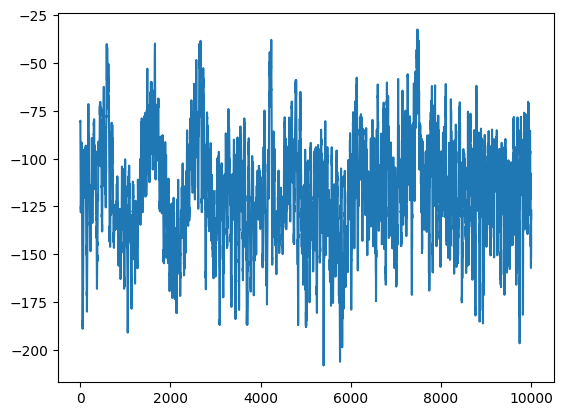

[(1+0j), (-0.4999999999999998+0.8660254037844387j), (-0.5000000000000004-0.8660254037844385j)]


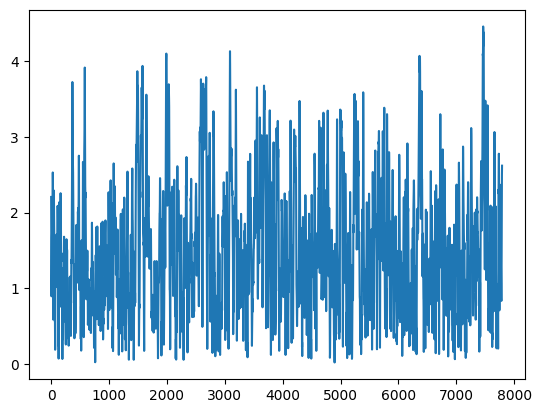

In [32]:
eeg = pd.read_parquet(paths.TRAIN_EEGS + '1628180742.parquet')
Fp1 = eeg['Fp1'][:10000]
plt.plot(Fp1)
plt.show()

smooth = pascal_smoother(Fp1,10)
plt.plot(dilate_skipper(norm(smooth), 1100, 3))
plt.show()